In [109]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from scipy import integrate
from tqdm.notebook import tqdm
import pickle

import sys
sys.path.append('..')

import jax.numpy as jnp
from jax import jit, vmap
from functools import partial

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

In [110]:
from utils.units_constants import *
from utils.geometry import *
from utils.galactic_models import *
from utils.nfw import *
from utils.map_utils import *

## 1. B field models

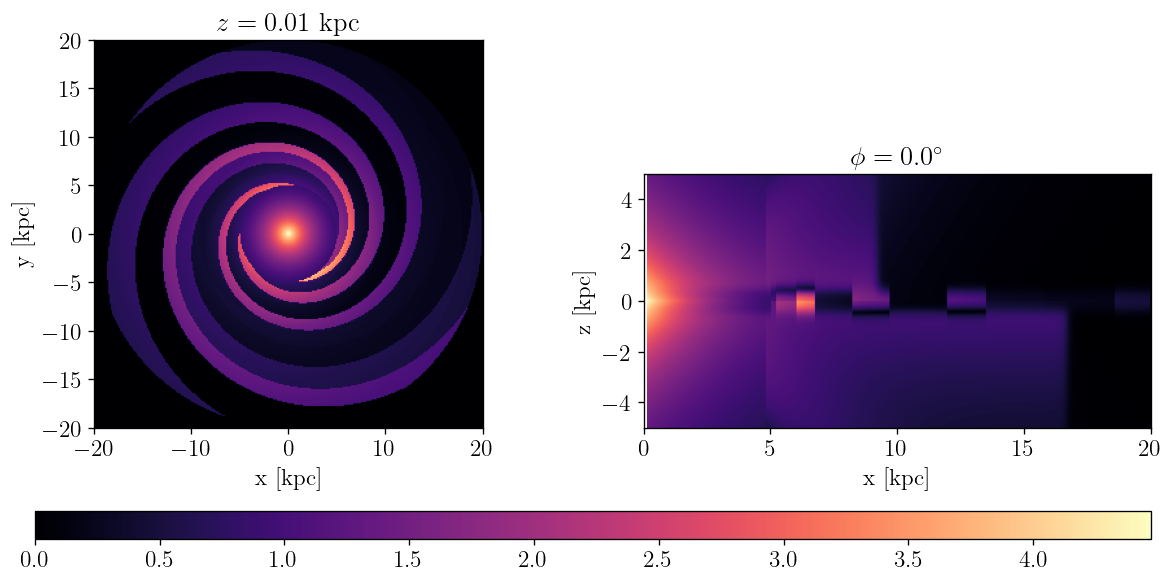

In [111]:
plot_hv(lambda x: jnp.linalg.norm(B_JF(x), axis=-1),
        smax=20, h_zval=0.01, zmax=5, v_tval=0, npix=300)

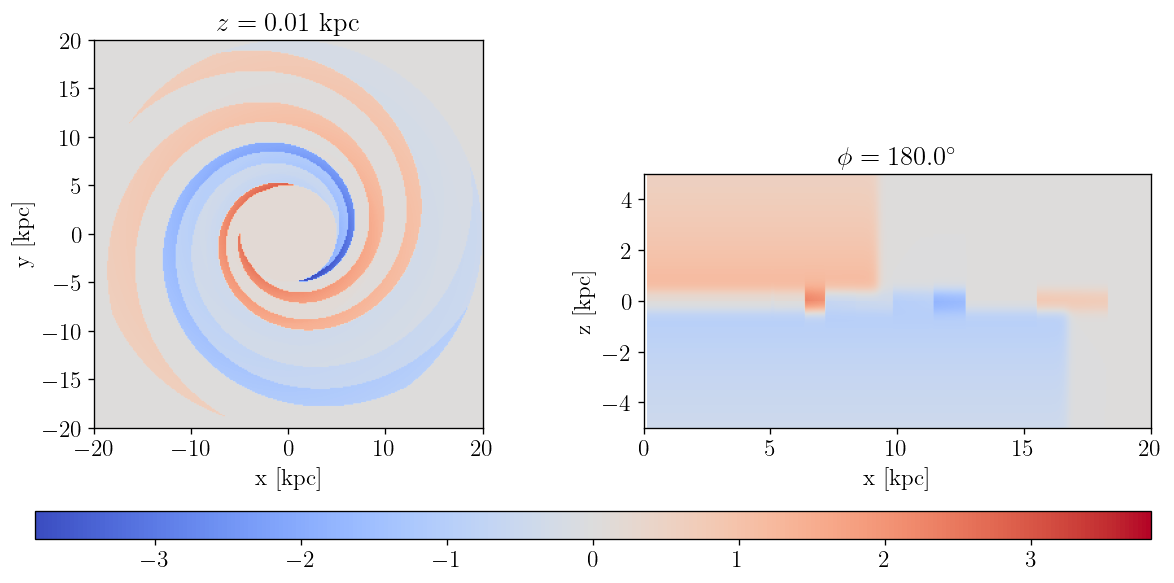

In [112]:
plot_hv(lambda x: B_JF(x)[:,1],
        smax=20, h_zval=0.01, zmax=5, v_tval=jnp.pi, npix=300, symm_color=True)

In [ ]:
plot_hv(lambda x: jnp.linalg.norm(B_disk_ASR(x), axis=-1),
        smax=20, h_zval=0, zmax=5, v_tval=0, npix=300)

In [ ]:
plot_hv(lambda x: jnp.linalg.norm(B_disk_BS(x), axis=-1),
        smax=20, h_zval=0, zmax=5, v_tval=0, npix=300)

In [ ]:
plot_hv(lambda x: jnp.linalg.norm(B_halo(x), axis=-1),
        smax=20, h_zval=1.5, zmax=5, v_tval=0, npix=300)

## 2. electron density

In [ ]:
plot_hv(n_e_SRWE, smax=20, h_zval=0, zmax=5, v_tval=0, npix=300)

In [ ]:
plot_hv(n_e_WMAP, smax=20, h_zval=0, zmax=5, v_tval=0, npix=300)

## 3. Synchrotron intensity (Sun location)

power density $p(\vec x)=n(\vec x)B(\vec x)^\alpha$

In [119]:
scheme = 'JF'
#gamma_NFW = 0.8

if scheme == 'AH':
    B_func = B_SRWE_AH
    n_e_func = n_e_SRWE
elif scheme == 'BH':
    B_func = B_SRWE_BH
    n_e_func = n_e_SRWE
elif scheme == 'JF':
    B_func = B_JF
    n_e_func = n_e_WMAP
else:
    raise ValueError(f'Unknown scheme.')

In [120]:
def power_density(stz):
    """Synchrotron intensity taking into account the direction of the B field.
    p [unnormalized] as a function of stz ([kpc], [rad], [kpc]). Vectorized manually;
    batch dimension is the first.
    """
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    LOS_vxyz = LOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, LOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha

In [121]:
@jit
@vmap
def I_src(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = power_density(GCstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

## 4. Create maps

In [122]:
# lower resolution map
pixel_size = 2 * deg # rad

n_b_pix = int(jnp.round(jnp.pi/pixel_size))
n_l_pix = int(jnp.round(2*jnp.pi/pixel_size))
b_edge_s = jnp.linspace(-jnp.pi/2, jnp.pi/2, n_b_pix+1)
l_edge_s = jnp.linspace(-jnp.pi, jnp.pi, n_l_pix+1)
b_s = (b_edge_s[:-1] + b_edge_s[1:]) / 2 # bin centers
l_s = (l_edge_s[:-1] + l_edge_s[1:]) / 2 # bin centers

l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.flatten(), b_grid.flatten()], axis=-1)

In [123]:
I_src_map = I_src(lb_flat).reshape((n_b_pix, n_l_pix))

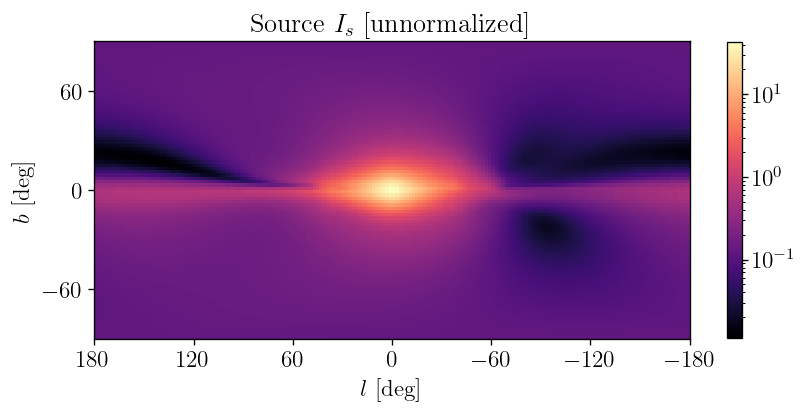

In [124]:
plot_lb(I_src_map, title=r'Source $I_s$ [unnormalized]')

## 5. Reference intensities

### 5.1 Naive gegenschein intensity

In [125]:
rho_integral_map = rho_integral(lb_flat).reshape((n_b_pix, n_l_pix))

In [126]:
Ig_map = antipodal_lb_map(I_src_map) * rho_integral_map

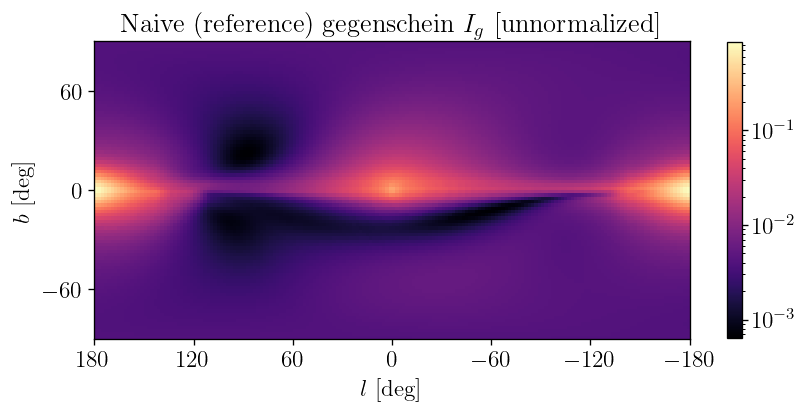

In [127]:
plot_lb(Ig_map, title=r'Naive (reference) gegenschein $I_g$ [unnormalized]')

### 5.2 Forwardschein reference intensity

In [128]:
If_map = I_src_map * rho_integral_ref # looks the same as souce I_s

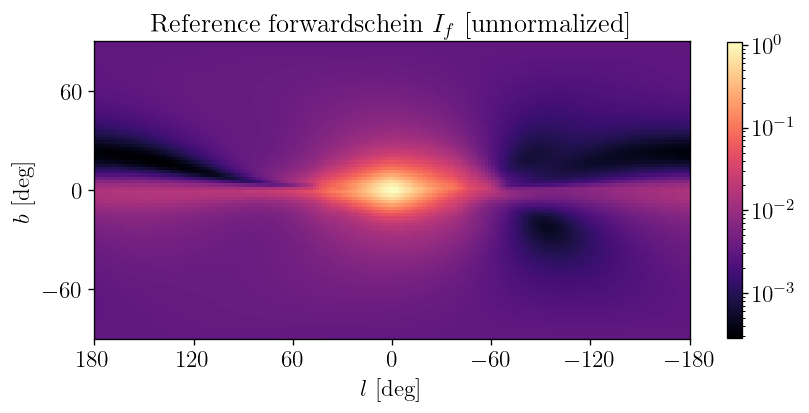

In [129]:
plot_lb(If_map, title=r'Reference forwardschein $I_f$ [unnormalized]')

## 6. Real scheins

### 6.1 Gegenschein (focused)

In [89]:
SIN_2SIGMAD = jnp.sin(2 * sigmad_over_c)
def x_d_gmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 - 2*sigmad_over_c) / SIN_2SIGMAD)

@jit
@partial(vmap, in_axes=(None, None, 0))
def drho_integral_from_zero(l, b, xdmax):
    """Integral rho dx [g/cm^2] as a function of l [rad], b [rad], xdmax [kpc]."""
    xds = jnp.logspace(jnp.log10(0.1), jnp.log10(xdmax), 300) # [kpc]
    lbd = jnp.stack([jnp.full_like(xds, l),
                     jnp.full_like(xds, b),
                     xds], axis=-1)
    return jnp.trapz(rho_NFW(Gr(lbd)), xds) * kpc

@jit
def Ig_focused(lb, theta_i0):
    """Focused gegenschein intensity [un.] as a funciton of (l, b) ([rad], [rad]),
    and valid image angle theta_i0 [rad].
    """
    l, b = lb
    xss = intg_d_s[1:]
    lbd = jnp.stack([jnp.full_like(xss, jnp.pi+l), # x_s in antipodal direction
                     jnp.full_like(xss, -b),
                     xss], axis=-1)
    xdmaxs = x_d_gmax(jnp.abs(xss), theta_i0)
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral_from_zero(l, b, xdmaxs), xss)

In [90]:
Ig_focused_map = []
for lb in tqdm(lb_flat):
    Ig_focused_map.append(Ig_focused(lb, jnp.pi/3))
Ig_focused_map = jnp.array(Ig_focused_map).reshape((n_b_pix, n_l_pix))

  0%|          | 0/16200 [00:00<?, ?it/s]

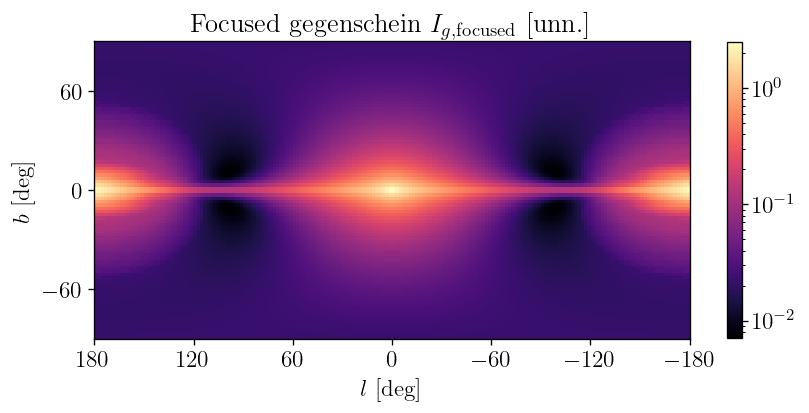

In [91]:
plot_lb(Ig_focused_map, title=r'Focused gegenschein $I_{g,\mathrm{focused}}$ [unn.]')

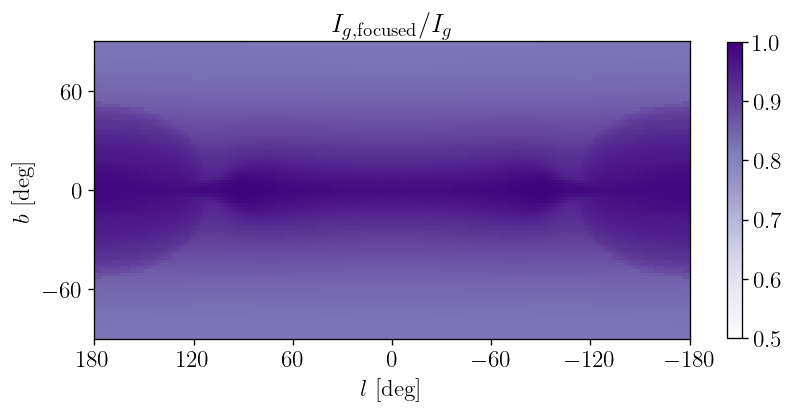

In [92]:
plot_lb(Ig_focused_map/Ig_map, log_norm=False, title=r'$I_{g,\mathrm{focused}} / I_g$',
        cmap='Purples', vmin=0.5, vmax=1)

### 6.2 Front gegenschein

In [93]:
def x_d_fgmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 + 2*sigmad_over_c) / SIN_2SIGMAD)

@jit
@partial(vmap, in_axes=(None, None, 0, 0))
def drho_integral(l, b, xdmin, xdmax):
    """Integral rho dx [g/cm^2] as a function of l [rad], b [rad], xdmin [kpc], xdmax [kpc]."""
    xds = jnp.logspace(jnp.log10(xdmin), jnp.log10(xdmax), 300) # [kpc]
    lbd = jnp.stack([jnp.full_like(xds, l),
                     jnp.full_like(xds, b),
                     xds], axis=-1)
    return jnp.trapz(rho_NFW(Gr(lbd)), xds) * kpc

@jit
def Ig_front(lb, theta_i0):
    """Front gegenschein intensity [un.] as a funciton of (l, b) ([rad], [rad]),
    and valid image angle theta_i0 [rad].
    """
    l, b = lb
    xss = intg_d_s[1:]
    lbd = jnp.stack([jnp.full_like(xss, l), # x_s in original direction
                     jnp.full_like(xss, b),
                     xss], axis=-1)
    xdmaxs = x_d_fgmax(xss, theta_i0)
    xdmins = xss
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral(l, b, xdmins, xdmaxs), xss)

In [94]:
Ig_front_map = []
for lb in tqdm(lb_flat):
    Ig_front_map.append(Ig_front(lb, jnp.pi/3))
Ig_front_map = jnp.array(Ig_front_map).reshape((n_b_pix, n_l_pix))

  0%|          | 0/16200 [00:00<?, ?it/s]

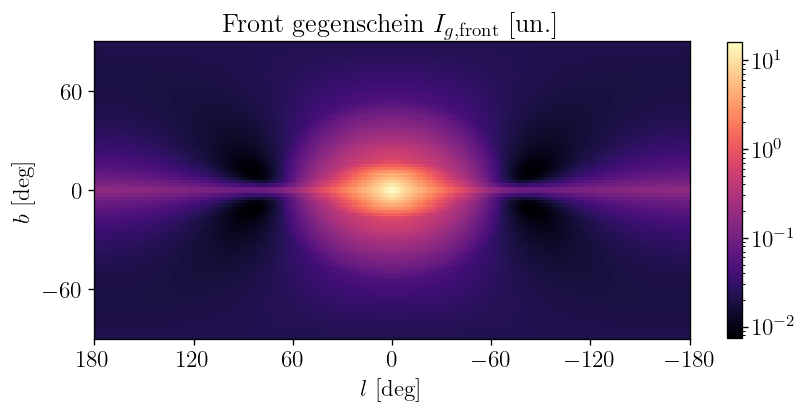

In [95]:
plot_lb(Ig_front_map, title=r'Front gegenschein $I_{g,\mathrm{front}}$ [un.]')

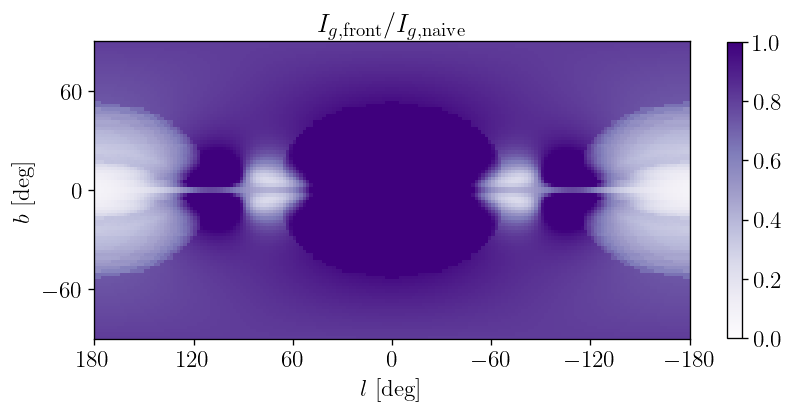

In [96]:
plot_lb(Ig_front_map/Ig_map, log_norm=False, title=r'$I_{g,\mathrm{front}}/I_{g,\mathrm{naive}}$',
        cmap='Purples', vmin=0, vmax=1)

### 6.3 Forwardschein

In [97]:
@jit
def I_forward(lb, theta_i0):
    """Forwardschein intensity [un.] as a funciton of (l, b) ([rad], [rad]),
    and valid image angle theta_i0 [rad].
    """
    l, b = lb
    xss = intg_d_s[1:]
    lbd = jnp.stack([jnp.full_like(xss, l), # x_s in original direction
                     jnp.full_like(xss, b),
                     xss], axis=-1)
    xdmaxs = xss
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral_from_zero(l, b, xdmaxs), xss)

In [98]:
I_forward_map = []
for lb in tqdm(lb_flat):
    I_forward_map.append(I_forward(lb, jnp.pi/3))
I_forward_map = jnp.array(I_forward_map).reshape((n_b_pix, n_l_pix))

  0%|          | 0/16200 [00:00<?, ?it/s]

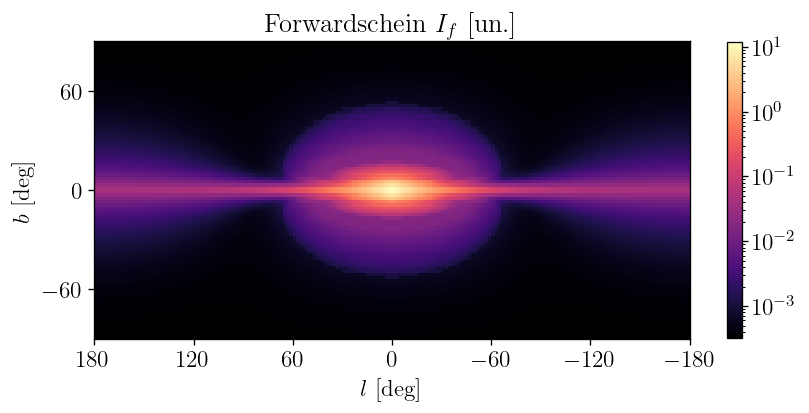

In [99]:
plot_lb(I_forward_map, title=r'Forwardschein $I_f$ [un.]')

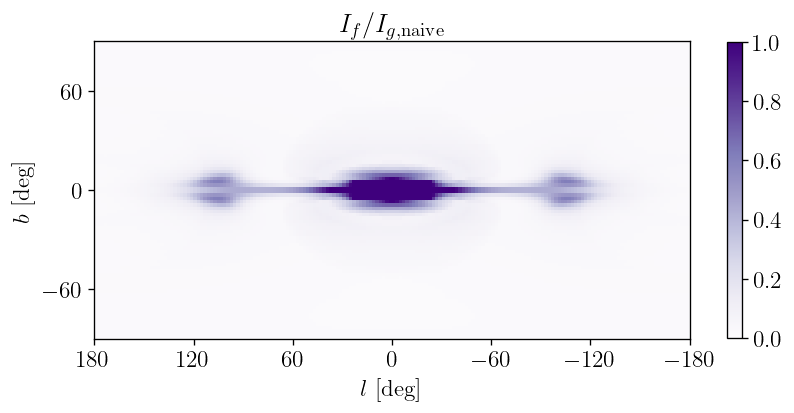

In [100]:
plot_lb(I_forward_map/Ig_map, log_norm=False, title=r'$I_f/I_{g,\mathrm{naive}}$',
        cmap='Purples', vmin=0, vmax=1)

## 7. Save data

In [105]:
save_dict = {
    'l': l_s,
    'b': b_s,
    'src': I_src_map,
    'naive': Ig_map,
    'focused': Ig_focused_map,
    'front': Ig_front_map,
    'forward': I_forward_map,
    'forward_ref': If_map,
}

In [106]:
SAVE_DIR = '../data/galactic_models'

In [107]:
pickle.dump(save_dict, open(f'{SAVE_DIR}/I_data_{scheme}_gamma08.dict', 'wb'))

In [108]:
! du -smh ../data/galactic_models/*

384K	../data/galactic_models/I_data_AH.dict
384K	../data/galactic_models/I_data_AH_gamma08.dict
384K	../data/galactic_models/I_data_BH.dict
384K	../data/galactic_models/I_data_JF.dict


# Appendix

## B. plot $I$ of different $B$, $n_e$ schemes

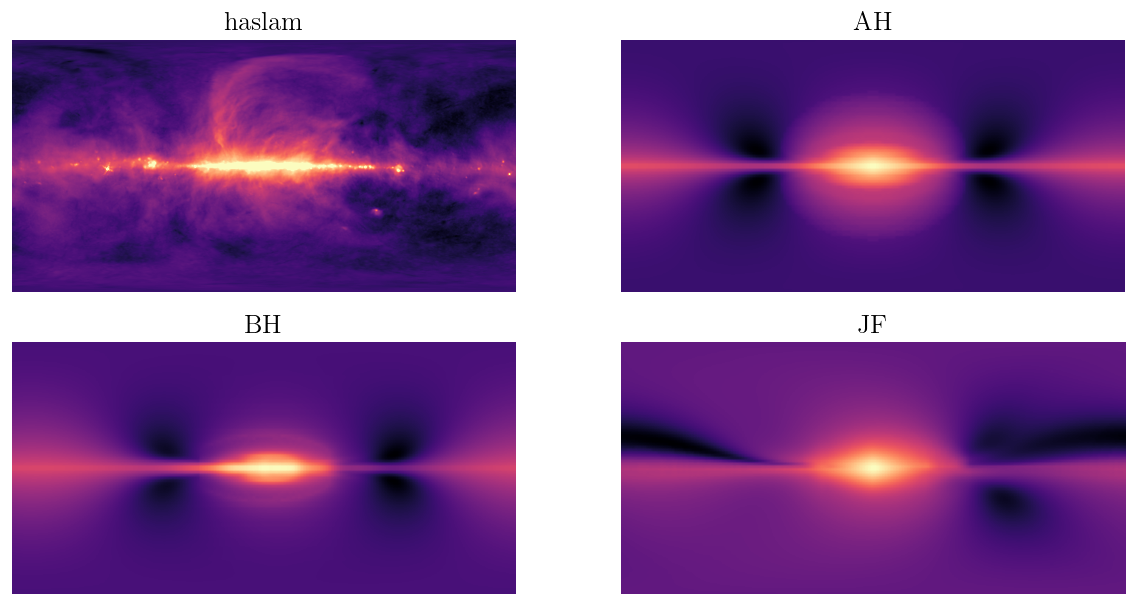

In [64]:
locs = [(0,1), (1,0), (1,1)]

fig, axs = plt.subplots(2, 2, figsize=(12,6))

haslam_map = np.load('../data/CHIME_estimate_intermediates/haslam_dsds_map.npy')
axs[0,0].imshow(jnp.log(jnp.flip(haslam_map)), cmap='magma', vmax=np.log(200))
axs[0,0].axis('off')
axs[0,0].set(title='haslam')

for i, scheme in enumerate(['AH', 'BH', 'JF']):
    save_dict = pickle.load(open(f'{SAVE_DIR}/I_data_{scheme}.dict', 'rb'))
    I_map = save_dict['src']
    axs[locs[i]].imshow(jnp.log(jnp.flip(I_map)), cmap='magma')
    axs[locs[i]].axis('off')
    axs[locs[i]].set(title=scheme)

## A. 3D galactic synchrotron model

Following [Radio observational constraints on Galactic 3D-emission models](https://arxiv.org/pdf/0711.1572.pdf)

### Coordinates
Cylindrical $(R, \phi, z)$ where $\phi=0$ corresponds to $l=0$ \
$R_\text{sun}$ is assumed to be 8.5 kpc.

### 6.1. Thermal electron density
#### 6.1.1. The model for diffuse ionized gas – NE2001
<img src="plots/NE2001.png" alt="drawing" width="400"/>

#### 6.1.2. The filling factor of the DIG – from free-free emission at 22.8 GHz
Filling factor of diffuse ionized gas (DIG)
$$f_e\equiv\frac{\langle n_e\rangle^2}{\langle n_e^2\rangle}$$
Berkhuijsen et al. (2006) derives
$$f_e(z)=\begin{cases}0.07\exp(|z|/0.5\text{kpc})\quad\\
  0.32\quad\text{for }z>0.75\text{kpc}\end{cases} $$

#### 6.1.3. The filling factor of the DIG – from low-frequency absorption
#### 6.1.4. Remarks
In summary the NE2001 model combined with the filling factor obtained by Berkhuijsen et al. (2006) are proven to be sufficient to model the low latitude DIG. 

### 6.2. Regular magnetic field properties
Total magnetic field = regular component + random component
$$B_\text{tot}=B+b.$$
Regular component has a disk and a halo component
$$B=B^D+B^H.$$
The former is constrained by RMs near the Galactic plane ($|b|<5^\circ$) and the latter by an all-sky RM map from EGS data.

#### 6.2.1. The disk field
Axi-symmetric spiral (ASS) or  Bi-symmetric spiral (BSS)

We collected a number of published models and
checked them for their ability to simulate the observed RMs in
the Galactic plane. The results are shown in Fig. 9. Obviously
none of the models is able to reproduce the observed systematic
features. This motivates us to revise the parameters previously
used.

\begin{equation}
\begin{cases}
B^D_R = D_1(R,\phi,z)D_2(R,\phi,z)\sin p \\
B^D_\phi = -D_1(R,\phi,z)D_2(R,\phi,z)\cos p \\
B^D_z = 0
\end{cases}
\end{equation}
where $D_1(R, \phi, z)$ constrains the spatial variation of the field
strength and $D_2(R, \phi, z)$ introduces reversals or asymmetries. $p$ is the pitch angle defined in the following graph (found [here](https://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1994A%26A...288..759H&defaultprint=YES&filetype=.pdf)):\
<img src="plots/pitch_angle.png" alt="drawing" width="400"/>

We use
$$D_1(R,z)=\begin{cases}
B_0\exp\left(-\frac{R-R_\bigodot}{R_0}-\frac{|z|}{z_0}\right)\quad &\text{for }R>R_c \\
B_c &\text{for }R<R_c\\
\end{cases}$$

The regular $z$-component of the Galactic magnetic field is
very small. Its strength is about 0.2 µG to 0.3 µG as estimated
by Han & Qiao (1994). We assume $B^D_z$ to be zero in our models.

We list three different magnetic field models
1. the Axi-symmetric Spiral (AS) model plus reversals in rings (AS+RING) -> ASR
1. the Axi-symmetric Spiral (AS) model plus reversals following arms (AS+ARM) -> ASA
1. the Bi-symmetric Spiral (BS) model -> BS

## Convention
cylindrical coordinates: s: radius, t: theta, z: height. \
batch dimension is always the first dimension.

#### 6.2.2 Halo regular field
<img src="plots/Halo_B_field.png" alt="drawing" width="400"/>

#### 6.3.2. CR electron density
<img src="plots/CRelec_text.png" alt="drawing" width="400"/>

### 3.1 Gegenschein (focused)

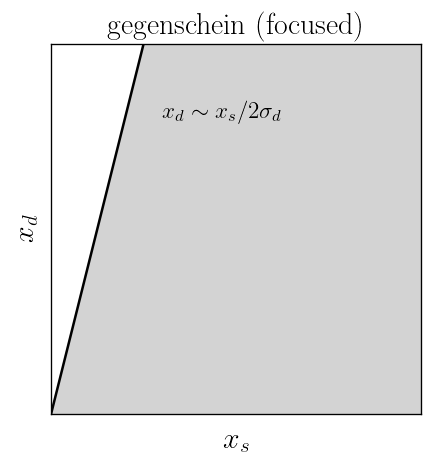

In [29]:
# gegenschein focused: allowed region
fig, ax = plt.subplots()
ax.plot([0,1],[0,4], 'k')
ax.fill_between([0,1],[0,4],[0,0], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='gegenschein (focused)')
ax.set(xticks=[], yticks=[])
ax.text(0.3, 0.8, r'$x_d\sim x_s/2\sigma_d$')
fig.savefig('gegenschein_region.pdf')

### 3.2 Front gegenschein

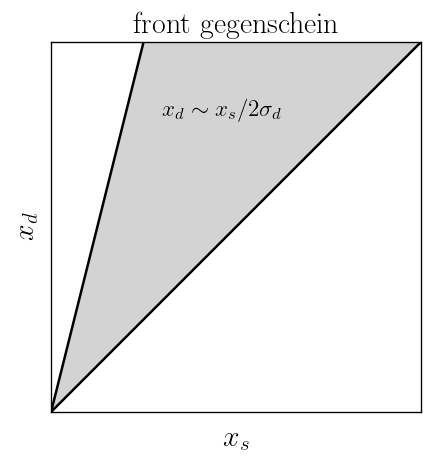

In [57]:
# front gegenschein: allow region
fig, ax = plt.subplots()
ax.plot([0,1],[0,4], 'k')
ax.plot([0,1],[0,1], 'k')
ax.fill_between([0,1],[0,4],[0,1], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='front gegenschein')
ax.set(xticks=[], yticks=[])
ax.text(0.3, 0.8, r'$x_d\sim x_s/2\sigma_d$')
fig.savefig('front_gegenschein_region.pdf')

### 3.3 Forwardschein

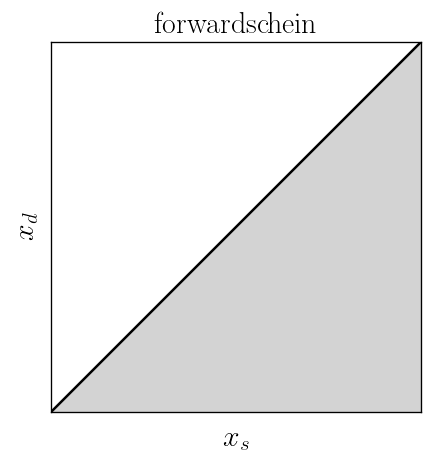

In [63]:
# forwardschein: allow region
fig, ax = plt.subplots()
ax.plot([0,1],[0,1], 'k')
ax.fill_between([0,1],[0,0],[0,1], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='forwardschein')
ax.set(xticks=[], yticks=[]);
fig.savefig('forwardschein_region.pdf')

# Tmp

## 4. Ratio

In [ ]:
fig, ax = plt.subplots()
ax.hist(((Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map).flatten(),
        bins=24, range=(1,15), color=plt.get_cmap('Purples')(0.7))
ax.set(yscale='log')
ax.set(xlabel='ratio', ylabel='pixel count', title='$I_\mathrm{total}/I_\mathrm{naive}$ distribution')
ax.set_xticks(np.linspace(1, 15, 14+1));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

im = ax.contourf(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart),
                 (Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map,
                 levels=np.linspace(0, 5, 10+1), cmap='Purples', extend='max')
# ax.contour(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart),
#            (Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map,
#            levels=[1.], linestyles=':')
ax.set(aspect='equal')
ax.invert_xaxis()
ax.set(xlabel='$l$ [deg]', ylabel='$b$ [deg]', title='Total $I/I_{g,\mathrm{naive}}$')
fig.colorbar(im, ax=ax, orientation='horizontal', aspect=40);

### 4.1 Generate ratio maps from I_data

In [42]:
NSIDE_target = 256
NPIX_target = hp.nside2npix(NSIDE_target)
print(f'Angular resolution ~ {hp.nside2resol(NSIDE_target, arcmin=True):.2f} arcmin')
print(f'Number of pixels: {NPIX_target}')

co_b_s_target, l_s_target = hp.pix2ang(NSIDE_target, range(NPIX_target))
b_s_target = np.pi/2 - co_b_s_target
lb_s_target = jnp.stack([l_s_target, b_s_target], axis=-1)

# antipodal indices
# anti_co_b_s = jnp.pi - co_b_s
# anti_l_s   = l_s + jnp.pi
# anti_inds = hp.ang2pix(NSIDE, anti_co_b_s, anti_l_s)

Angular resolution ~ 13.74 arcmin
Number of pixels: 786432


In [79]:
B_scheme = 'AR_H'
I_data = pickle.load(open(f'I_data_{B_scheme}.dict', 'rb'))
print(I_data.keys())

dict_keys(['naive', 'naive_cart', 'focused', 'focused_cart', 'front', 'front_cart', 'forward', 'forward_cart', 'forward_ref', 'forward_ref_cart'])


In [80]:
g_ratio_map = I_data['focused']/I_data['naive']
f_ratio_map = (I_data['front'] + I_data['forward'])/I_data['forward_ref']
g_ratio_map_upsampled = hp.pixelfunc.get_interp_val(g_ratio_map, co_b_s_target, l_s_target)
f_ratio_map_upsampled = hp.pixelfunc.get_interp_val(f_ratio_map, co_b_s_target, l_s_target)
#ratio_map_upsampled = hp.pixelfunc.ud_grade(ratio_map, NSIDE)
ratio_dict = {
    'g_ratio': g_ratio_map_upsampled,
    'f_ratio': f_ratio_map_upsampled
}
pickle.dump(ratio_dict, open(f'ratios_{B_scheme}.dict', 'wb'))